# Predictive Modelling – Customer Holiday Booking
Objective: The objective of this analysis was to develop a predictive model capable of identifying customers likely to complete a holiday booking. This enables British Airways to proactively target high-intent customers before travel, improving marketing efficiency and conversion rates.

In [732]:
import pandas as pd

Load dataset

In [733]:
df = pd.read_csv("./data/customer_booking.csv", encoding="latin1")

## Data Exploration

In [734]:
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [735]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  str    
 2   trip_type              50000 non-null  str    
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  str    
 7   route                  50000 non-null  str    
 8   booking_origin         50000 non-null  str    
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), str(5)
memory usage: 5.3 MB


In [736]:
df.shape

(50000, 14)

how many booked tickets (actual values)

In [737]:
df["booking_complete"].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

how many booked tickets in percentage

In [738]:
actualBookings = df["booking_complete"].value_counts(normalize=True)
percentageBookings = actualBookings * 100
print(percentageBookings)

booking_complete
0    85.044
1    14.956
Name: proportion, dtype: float64


In [739]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


Capping extreme values using percentile method

In [740]:
df["purchase_lead"].quantile(0.99)

np.float64(390.0)

In [741]:
df["length_of_stay"].quantile(0.99)

np.float64(168.0)

In [742]:
# Cap purchase_lead at 99th percentile
df["purchase_lead"] = df["purchase_lead"].clip(upper=390)

In [743]:
# Cap length_of_stay at 99th percentile
df["length_of_stay"] = df["length_of_stay"].clip(upper=168)

In [744]:
print(df["purchase_lead"].max())

390


In [745]:
print(df["length_of_stay"].max())

168


## Data Preparation

Encoding categorical variables (very important for RandomForest).

In [746]:
print("sales_channel:", df["sales_channel"].nunique())
print("trip_type:", df["trip_type"].nunique())
print("flight_day:", df["flight_day"].nunique())
print("route:", df["route"].nunique())
print("booking_origin:", df["booking_origin"].nunique())

sales_channel: 2
trip_type: 3
flight_day: 7
route: 799
booking_origin: 104


In [747]:
df["booking_origin"].unique()[:20]

<StringArray>
[         'New Zealand',                'India',       'United Kingdom',
                'China',          'South Korea',                'Japan',
             'Malaysia',            'Singapore',          'Switzerland',
              'Germany',            'Indonesia',       'Czech Republic',
              'Vietnam',             'Thailand',                'Spain',
              'Romania',              'Ireland',                'Italy',
             'Slovakia', 'United Arab Emirates']
Length: 20, dtype: str

In [748]:
df["booking_origin"].value_counts().head(10)

booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64

In [749]:
# Define region mapping
region_map = {
    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    
    # Southeast Asia
    "Malaysia": "SE_Asia",
    "Singapore": "SE_Asia",
    "Indonesia": "SE_Asia",
    "Thailand": "SE_Asia",
    "Vietnam": "SE_Asia",
    
    # East Asia
    "China": "East_Asia",
    "Japan": "East_Asia",
    "South Korea": "East_Asia",
    "Taiwan": "East_Asia",
    
    # South Asia
    "India": "South_Asia",
    
    # Europe
    "United Kingdom": "Europe",
    "Germany": "Europe",
    "Switzerland": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Ireland": "Europe",
    "Czech Republic": "Europe",
    "Slovakia": "Europe",
    "Romania": "Europe",
    
    # Middle East
    "United Arab Emirates": "Middle_East"
}


In [750]:
df["origin_region"] = df["booking_origin"].map(region_map)


In [751]:
df["origin_region"] = df["origin_region"].fillna("Other")


In [752]:
df["origin_region"].value_counts()


origin_region
Oceania        18946
East_Asia      13908
SE_Asia        13005
Other           2474
South_Asia      1270
Europe           355
Middle_East       42
Name: count, dtype: int64

In [753]:
df["origin_region"] = df["origin_region"].replace(
    ["Europe", "Middle_East"], "Other"
)


In [754]:
df["origin_region"].value_counts()


origin_region
Oceania       18946
East_Asia     13908
SE_Asia       13005
Other          2871
South_Asia     1270
Name: count, dtype: int64

In [755]:
df = df.drop(columns=["booking_origin", "route"])


In [756]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete', 'origin_region'],
      dtype='str')

In [757]:
# Separating features and target
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

In [758]:
# Applying One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

In [759]:
X.shape

(50000, 21)

In [760]:
X.head(5)

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,trip_type_OneWay,...,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,origin_region_Oceania,origin_region_Other,origin_region_SE_Asia,origin_region_South_Asia
0,2,262,19,7,1,0,0,5.52,False,False,...,False,True,False,False,False,False,True,False,False,False
1,1,112,20,3,0,0,0,5.52,False,False,...,False,True,False,False,False,False,True,False,False,False
2,2,243,22,17,1,1,0,5.52,False,False,...,False,False,False,False,False,True,False,False,False,True
3,1,96,31,4,0,0,1,5.52,False,False,...,False,True,False,False,False,False,True,False,False,False
4,2,68,22,15,1,0,1,5.52,False,False,...,False,False,False,False,False,True,False,False,False,True


## Feature Engineering

In [761]:
def hour_bucket(h):
    if 0 <= h <= 5:
        return "Night"
    elif 6 <= h <= 11:
        return "Morning"
    elif 12 <= h <= 17:
        return "Afternoon"
    else:
        return "Evening"

df["flight_time_bucket"] = df["flight_hour"].apply(hour_bucket)


In [762]:
df = df.drop(columns=["flight_hour"])


In [763]:
# Create haul_type from flight duration
def haul_bucket(d):
    if d < 6:
        return "Short"
    elif d < 8:
        return "Medium"
    else:
        return "Long"

df["haul_type"] = df["flight_duration"].apply(haul_bucket)


In [764]:
# Create “engagement score” from add-ons
df["addon_count"] = (
    df["wants_extra_baggage"] +
    df["wants_preferred_seat"] +
    df["wants_in_flight_meals"]
)


In [765]:
# Rebuild X/y + One-hot Encode Again
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

X = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Feature Importance

In [766]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top 10
feature_importance_df.head(7)


,Feature,Importance
1,purchase_lead,0.203324
2,length_of_stay,0.154197
19,origin_region_SE_Asia,0.104990
6,flight_duration,0.099765
17,origin_region_Oceania,0.095050
0,num_passengers,0.048418
7,addon_count,0.031519


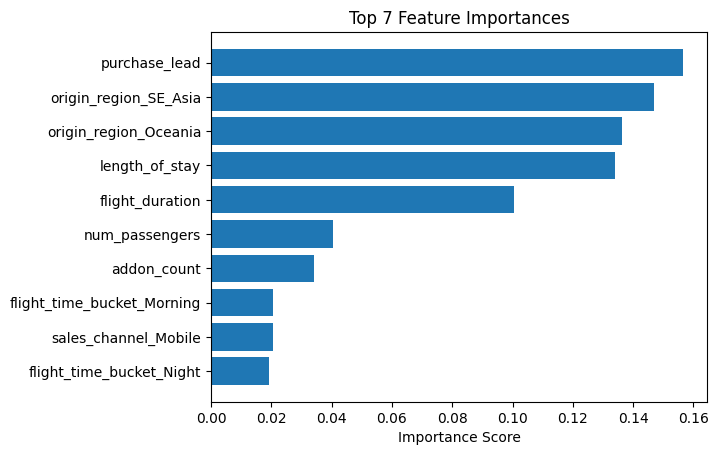

In [775]:
import pandas as pd

importances = best_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_features = feature_importance_df.head(10)

plt.figure()
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 7 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


In [768]:
# Create reverse mapping: region -> list of countries
region_country_map = {}

for country, region in region_map.items():
    region_country_map.setdefault(region, []).append(country)

# Convert to DataFrame for clean display
region_df = pd.DataFrame(
    [(region, ", ".join(countries)) 
     for region, countries in region_country_map.items()],
    columns=["Region", "Countries"]
)

region_df


,Region,Countries
0,Oceania,"Australia, New Zealand"
1,SE_Asia,"Malaysia, Singapore, Indonesia, Thailand, Vietnam"
2,East_Asia,"China, Japan, South Korea, Taiwan"
3,South_Asia,India
4,Europe,"United Kingdom, Germany, Switzerland, Italy, S..."
5,Middle_East,United Arab Emirates


## Key Predictive Drivers
- Purchase lead time
- Length of stay
- Flight timing & haul type
- Origin region
- Add-on engagement


## Model Training

In [769]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    min_samples_leaf=3,
    max_depth=None,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

# Predicting and Evaluating Model

In [770]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_proba = rf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

t = 0.4
y_pred_t = (y_proba >= t).astype(int)
print("\nThreshold:", t)
print(confusion_matrix(y_test, y_pred_t))
print(classification_report(y_test, y_pred_t))


ROC-AUC: 0.761929743033791

Threshold: 0.4
[[6484 2020]
 [ 577  919]]
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      8504
           1       0.31      0.61      0.41      1496

    accuracy                           0.74     10000
   macro avg       0.62      0.69      0.62     10000
weighted avg       0.83      0.74      0.77     10000



A lower threshold (0.4) was selected to prioritise recall, as missing potential high-intent customers is more costly than contacting low-intent customers.

## Cross-Validation

In [771]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_rf,
    X,
    y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("Stratified CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())
print("Std Dev:", cv_scores.std())


Stratified CV ROC-AUC scores: [0.74900729 0.76134578 0.75941944 0.75680161 0.75378133]
Mean CV ROC-AUC: 0.7560710902427352
Std Dev: 0.00435218740852178


## Visualization

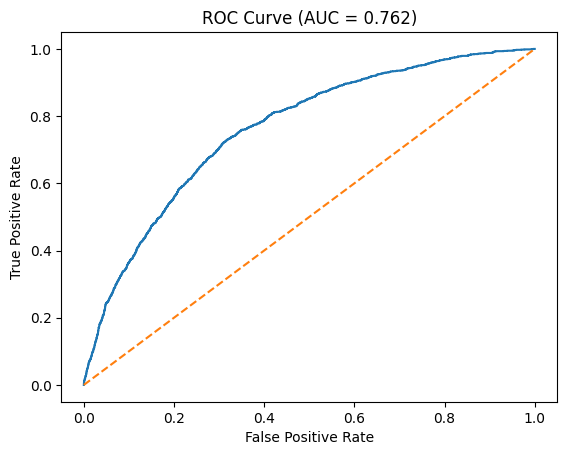

In [772]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()


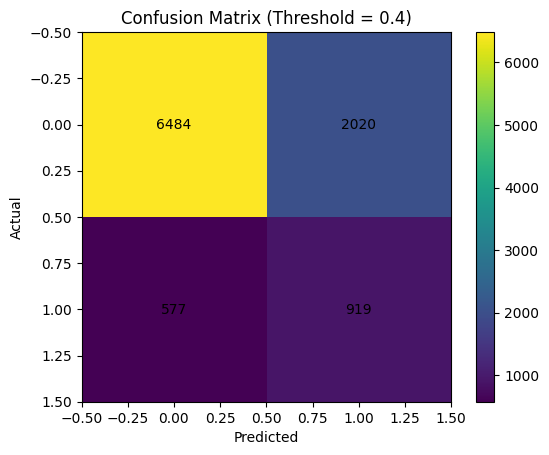

In [773]:
from sklearn.metrics import confusion_matrix
import numpy as np

threshold = 0.4
y_pred_final = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_final)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


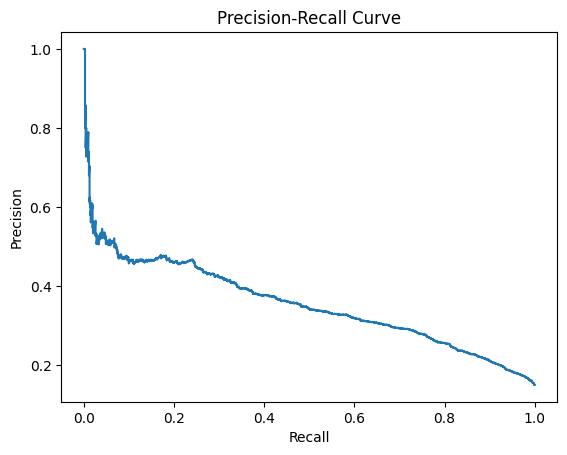

In [774]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


## Final Model Summary
- Algorithm: Random Forest (class balanced)
- ROC-AUC: 0.76
- Recall (Threshold 0.4): 61%
- Precision: 31%
- Stratified CV Mean AUC: 0.756 ± 0.004


## Business Implications

The model can be deployed as a decision-support tool within marketing workflows to:

 - Prioritise high-intent customers

 - Improve campaign conversion rates

 - Reduce inefficient outreach

 - Support proactive sales strategy

The model is not designed for full automation but serves as a strong predictive ranking tool.

## Recommendations for Future Improvement

Further performance gains may be achieved through:

 - Incorporating historical customer booking behaviour

 - Adding loyalty programme data

 - Including browsing/session activity signals

## Final Conclusion

The predictive model successfully demonstrates stable and meaningful separation between booking and non-booking customers. With appropriate threshold tuning, it provides actionable insights that support proactive marketing and revenue optimisation.